In [1]:
from __future__ import print_function

import os
import numpy as np
# import torch
# import pandas as pd
from io import StringIO
# from google.cloud import storage
import matplotlib.pyplot as plt#, mpld3
from sklearn import ensemble
from sklearn.preprocessing import MinMaxScaler
# Keras
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.metrics import binary_accuracy
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten
from keras.layers.core import Dense, Dropout, Activation, Layer, Lambda, Flatten
from keras.regularizers import l2
from keras.optimizers import RMSprop, Adadelta, adam
import random
seed = 0 #0
np.random.seed(seed=seed)
random.seed(seed)

%matplotlib inline
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../ab2.json"

Using TensorFlow backend.


# Load data from numpy arrays

In [2]:
def load_data_file(data_file):
    
    data = np.load(data_file)
    
    if data.ndim == 1:
        data = data[None, :]
    
    params_dim = 28
    observation_dim = 4379 # observation size, no clouds, final decision data size
    full_dim = 15346

    obs_index_s = params_dim+full_dim
    obs_index_e = params_dim+full_dim+observation_dim - 1
    # noise_ind = params_dim+2*full_dim:params_dim+2*full_dim+observation_dim
    x = data[:,obs_index_s:obs_index_e] # Observations (No noise) 
    y = data[:,14:26]
#     y = data[:,8:26] # INCLUDE IF MICHAEL WANTS THIS FULL RANGE OF TEMP PARAMS
    
    return x, y

## Files to be downloaded

In [3]:
# num_features = 20
files = ['combined_63f3a5ce-83c7-4975-9dcb-bcb917498cf1.npy',
'combined_6a57d8fb-2b4a-4ced-9afe-ed617699e289.npy',
'combined_745da2f5-6a42-4f32-8bba-2859452574d0.npy',
'combined_7f3d7521-49e3-4e5c-ad41-8cc4d86d5176.npy',
'combined_9d457f90-82cb-460a-94df-e6a51941a7fa.npy',
'combined_adac07ee-8112-413e-b184-4d8edbaef81f.npy',
'combined_be02d725-3bc9-43ee-a288-8233f1c4ec6e.npy',
'combined_d6eb9c5a-022a-4017-8206-fe751dad2b8c.npy',
'combined_eda2d15f-b20f-4206-961c-d401f37b8777.npy',
'combined_f02ad58c-1295-40af-8e4a-dcf4f6ede933.npy']
x_data, y_data = load_data_file(data_file='../train/' + files[0])
for file in files[1:]:
    x, y = load_data_file(data_file='../train/' + file)
    x_data = np.vstack([x_data,x])
    y_data = np.vstack([y_data,y])
    print(file, ' Complete')
    

combined_6a57d8fb-2b4a-4ced-9afe-ed617699e289.npy  Complete
combined_745da2f5-6a42-4f32-8bba-2859452574d0.npy  Complete
combined_7f3d7521-49e3-4e5c-ad41-8cc4d86d5176.npy  Complete
combined_9d457f90-82cb-460a-94df-e6a51941a7fa.npy  Complete
combined_adac07ee-8112-413e-b184-4d8edbaef81f.npy  Complete
combined_be02d725-3bc9-43ee-a288-8233f1c4ec6e.npy  Complete
combined_d6eb9c5a-022a-4017-8206-fe751dad2b8c.npy  Complete
combined_eda2d15f-b20f-4206-961c-d401f37b8777.npy  Complete
combined_f02ad58c-1295-40af-8e4a-dcf4f6ede933.npy  Complete


# Training / Validation split

* Consider taking log 10 of data (Being careful not to take the log of the temperature features if they are included)

In [4]:
Ntr = 80000
Nval = 10000
Ntest = 7000
num_features = 5
x_data_tr = x_data[:Ntr,:] # array of no.Planets x Observations
y_data_tr = y_data[:Ntr,:num_features] # array of no.Planets x Abundances
x_data_val = x_data[Ntr:Ntr+Nval,:]
y_data_val = y_data[Ntr:Ntr+Nval,:num_features]
x_data_te = x_data[Ntr+Nval:Ntr+Nval+Ntest,:]
y_data_te = y_data[Ntr+Nval:Ntr+Nval+Ntest,:num_features]

In [5]:
y_data.shape

(97705, 12)

In [6]:
# x_range = x_data.max(0) - x_data.min(0)
# y_range = y_data.max(0) - y_data.min(0)

## Normalise: remove mean and divide by standard deviation

In [7]:
# Normalise
x_data_tr = (x_data_tr - x_data.mean(0))/x_data.std(0)
x_data_val = (x_data_val - x_data.mean(0))/x_data.std(0)
x_data_te = (x_data_te - x_data.mean(0))/x_data.std(0)

# y_data_tr = (y_data_tr - y_data.mean(0)[:num_features])/y_data.std(0)[:num_features]
# y_data_val = (y_data_val - y_data.mean(0)[:num_features])/y_data.std(0)[:num_features]
# y_data_te = (y_data_te - y_data.mean(0)[:num_features])/y_data.std(0)[:num_features]


# x_data_tr = (x_data_tr - x_data.min(0)) / ( x_range)
# x_data_val = (x_data_val - x_data.min(0)) / (x_range)

# y_data_tr = (y_data_tr - y_data.min(0)) / ( y_range)
# y_data_val = (y_data_val - y_data.min(0)) / (y_range)

In [8]:
y_data_tr

array([[0.05447795, 0.36356334, 0.39322633, 0.02347669, 0.12807289],
       [0.0416023 , 0.19883195, 0.31969715, 0.37276586, 0.0456813 ],
       [0.03258097, 0.33018416, 0.22527762, 0.3673055 , 0.02988821],
       ...,
       [0.00196283, 0.2791712 , 0.40897972, 0.2534292 , 0.04148659],
       [0.00272621, 0.274068  , 0.3625812 , 0.33963863, 0.00242195],
       [0.01073858, 0.02881292, 0.59548556, 0.2534794 , 0.06250082]])

## Select abundances for outputs

In [9]:
num_features = 5 # Select first 5 abundances

y_data_tr = y_data_tr[:,:num_features]
y_data_val = y_data_val[:,:num_features]
y_data_te = y_data_te[:,:num_features]

In [10]:
names =  ["H20", "CO2", "O2", "N2", "CH4"]
# ranges =  [[0, 3000], [-13, 0], [-13, 0], [-13, 0], [-13, 0]],
# colors  = ["#F14532", "#4a98c9", "#f4701b", "#4bb062", "#6363d8"],

In [11]:
x_data_tr = np.squeeze(x_data_tr)
x_data_val = np.squeeze(x_data_val)

## For a CNN you need to add a channel at the end which is done in the cell below.
* If you want to use a FF NN, use the above cell and dont run the one below

In [12]:
# CNN
x_data_tr = np.expand_dims(x_data_tr,2)
x_data_val = np.expand_dims(x_data_val,2)
x_data_te = np.expand_dims(x_data_val,2)

In [13]:
x_data_val.shape

(10000, 4378, 1)

In [14]:
y_data_val.shape

(10000, 5)

In [15]:
Early_Stop_acc = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
# units
# units = 200
batch_size = 128
epochs = 10
dropout = 0.05
# Regularise
tau = 10000
lengthscale = .01
reg = lengthscale**2 * (1 - dropout) / (2. * Ntr * tau)

# nb_filter = 64
# filter_length = 5
def network():
    model = Sequential()
    model.add(Convolution1D(nb_filter=64, kernel_size=2, activation='linear', input_shape=(x_data.shape[1], 1)))
    model.add(Convolution1D(nb_filter=64, kernel_size=2, activation='relu', input_shape=(x_data.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Convolution1D(nb_filter=128, kernel_size=2, activation='linear', input_shape=(x_data.shape[1], 1)))
    model.add(Convolution1D(nb_filter=128, kernel_size=2, activation='relu', input_shape=(x_data.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Convolution1D(nb_filter=128, kernel_size=2, activation='linear', input_shape=(x_data.shape[1], 1)))
    model.add(Convolution1D(nb_filter=128, kernel_size=2, activation='relu', input_shape=(x_data.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Convolution1D(nb_filter=128, kernel_size=2, activation='linear', input_shape=(x_data.shape[1], 1)))
    model.add(Convolution1D(nb_filter=128, kernel_size=2, activation='relu', input_shape=(x_data.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(y_data_tr.shape[-1], activation='softmax'))
              #     model.add(Dense(units, activation='relu', input_shape=x_data_tr.shape[1:],W_regularizer=l2(reg)))
#     model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
#     model.add(Dense(units, activation='relu',W_regularizer=l2(reg)))
#     model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
#     model.add(Dense(units, activation='relu',W_regularizer=l2(reg)))
#     model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
#     model.add(Dense(units, activation='relu',W_regularizer=l2(reg)))
#     model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
# #     model.add(Dense(y_data_tr.shape[-1], activation='relu',W_regularizer=l2(reg)))
# #     model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
#     model.add(Dense(y_data_tr.shape[-1], activation='linear',W_regularizer=l2(reg)))
    return model

In [16]:
reg

5.9375e-14

## Setting up the random seed

In [17]:
np.random.seed(seed=seed)
random.seed(seed)

N_ensemble = 1  #Number of networks in ensemble (I suggest sticking with 1)

## Training

In [18]:
nn_ensemble = []
training = True
weights_file_std = '../model/cnn3_weights.h5'   # Path to model weights
if training:
    for nn in range(N_ensemble):
        np.random.seed(seed=nn)
        random.seed(nn)
        # model_checkpoint: saves depending on validation
        model_checkpoint =  keras.callbacks.ModelCheckpoint(weights_file_std, monitor='val_loss', save_best_only=True,
                                           save_weights_only=True, mode='auto',verbose=0)

        std_model = network()
        std_model.compile(loss='mean_squared_error',
                          optimizer='adam')

        history_std = std_model.fit(x_data_tr, y_data_tr,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=[x_data_val,y_data_val],
                          callbacks=[model_checkpoint])
        std_model.load_weights(weights_file_std)  # Load model with best validation loss
        nn_ensemble.append(std_model)
        print(nn, ' COMPLETED')
else:
    if N_ensemble > 1:
        print('Loading models not currently working for ensemble')
    std_model = network()
    std_model.compile(loss='mean_squared_error',
                          optimizer='adam')
    std_model.load_weights(weights_file_std)
    nn_ensemble.append(std_model)

/home/kenobi/anaconda2/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=2, activation="linear", input_shape=(4378, 1), filters=64)`
  app.launch_new_instance()
/home/kenobi/anaconda2/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=2, activation="relu", input_shape=(4378, 1), filters=64)`
/home/kenobi/anaconda2/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=2, activation="linear", input_shape=(4378, 1), filters=128)`
/home/kenobi/anaconda2/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=2, activation="relu", input_shape=(4378, 1), filters=128)`
/home/kenobi/anaconda2/envs/tf18/lib/python3.6/site-packages/ipykernel

Train on 80000 samples, validate on 10000 samples
Epoch 1/10
80000/80000 [==============================] - 72s 896us/step - loss: 0.0163 - val_loss: 0.0158
Epoch 2/10
34688/80000 [============>.................] - ETA: 37s - loss: 0.0160

KeyboardInterrupt: 

In [19]:
# std_model.load_weights(weights_file_std)
# nn_ensemble.append(std_model)

In [25]:
# nn_ensemble[0].save_weights('../model/weights_cnn_inara_1_network.h5')

In [26]:
# nn_ensemble = []
# for n in range(N_ensemble):
#     std_model = network()
#     std_model.load_weights('../model/HELA_weights_std_inara_'+str(n)+'.h5')
#     nn_ensemble.append(std_model)

In [20]:
std_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 4377, 64)          192       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4376, 64)          8256      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2188, 64)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2187, 128)         16512     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2186, 128)         32896     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1093, 128)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1092, 128)         32896     
__________

### RMSE for different combos (grid search :( )

In [21]:
# # test denorm error for min norm (2 * tanh)
# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_range + y_data.min(0)
# y_data_val_denorm = y_data_val * y_range + y_data.min(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# # (9999, 5)
# # [358.32918551   2.31141618   2.72354071   2.24373828   2.22574402]

In [22]:
# # test denorm error for mean norm (2 * tanh)
# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_data.std(0) + y_data.mean(0)
# y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# # (9999, 5)
# # [348.33966495   2.28236494   2.71438089   2.16008919   2.17986165]

In [23]:
# # test denorm error for mean norm (4 * relu, 1024 units)
# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_data.std(0) + y_data.mean(0)
# y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# (9999, 5)
# [335.42021214   2.25643578   2.66284313   2.10965753   2.14305779]

In [24]:
# # test denorm error for mean norm (4 * relu, 2048 units)
# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_data.std(0) + y_data.mean(0)
# y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# (9999, 5)
# [337.87892212   2.29054677   2.65926488   2.0926183    2.15020789]

In [25]:
# # test denorm error for mean norm (4 * relu, units 3,2,1)
# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_data.std(0) + y_data.mean(0)
# y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# (9999, 5)
# [335.37262741   2.27267598   2.65470067   2.0803818    2.15800546]

In [26]:
# # test denorm error for mean norm (4 * relu, 2048 units)
# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_data.std(0) + y_data.mean(0)
# y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# (9999, 5)
# [344.86893266   2.27918209   2.67477766   2.19067704   2.18239063]

In [27]:
# # # test denorm error for mean norm (2 * tanh, 1024 units)
# preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
# preds_denorm = preds * y_data.std(0) + y_data.mean(0)
# y_data_val_denorm = y_data_val * y_data.std(0) + y_data.mean(0)
# print(preds_denorm.shape)
# rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
# print(rmse)
# (9999, 5)
# [342.9679369    2.27894085   2.68276775   2.14159416   2.18107573]

In [28]:
# # test denorm error for mean norm (2 * tanh, 1024 units)
preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
preds_denorm = preds * y_data.std(0)[:5] + y_data.mean(0)[:5]
y_data_val_denorm = y_data_val * y_data.std(0)[:5] + y_data.mean(0)[:5]
print(preds_denorm.shape)
rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
print(rmse)

(10000, 5)
[0.02522992 0.15793532 0.15240601 0.15992817 0.02513893]


In [35]:
# # test denorm error for mean norm (2 * tanh, 1024 units)
preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
preds_denorm = preds * y_data.std(0)[:5] + y_data.mean(0)[:5]
y_data_val_denorm = y_data_val * y_data.std(0)[:5] + y_data.mean(0)[:5]
print(preds_denorm.shape)
rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
print(rmse)

(500, 5)
[0.02019119 0.11775095 0.09987461 0.1489149  0.01679041]


In [35]:
# # test denorm error for mean norm (1 epoch)
preds = np.mean([std_model.predict([x_data_val]) for _ in range(20)], 0)
preds_denorm = preds * y_data.std(0)[:5] + y_data.mean(0)[:5]
y_data_val_denorm = y_data_val * y_data.std(0)[:5] + y_data.mean(0)[:5]
print(preds_denorm.shape)
rmse = np.mean((preds_denorm - y_data_val_denorm)**2., 0)**0.5
print(rmse)

(10000, 5)
[0.02522289 0.15797298 0.15244118 0.15991646 0.02513462]


### Validation

In [36]:
# x_data_test, y_data_test = x_data_val, y_data_val #load_data_file(data_file='../test/testing_hela.npy', num_features=num_features)

In [37]:
x_data_val.std(0)

array([[1.00158265],
       [1.00157215],
       [1.00155453],
       ...,
       [0.96769188],
       [0.96593488],
       [0.96611634]])

# Prediction on one point just to check it is working (operating)

In [21]:
T = 10 # No. dropout masks -> number of samples of output for same input
planet_id = 0 # This is just the planet you are currentlly looking at.
predictions_val = np.zeros((N_ensemble,T,num_features))
n = 0
for std_model in nn_ensemble:
    predictions_val[n] = np.array([std_model.predict([x_data_val[planet_id].reshape((1,-1,1))]).reshape((1,num_features)) for _ in range(T)]).squeeze()
    print('Model in ensemble completed: ', n)
    n += 1

Model in ensemble completed:  0


# Reshape so we can plot 

In [22]:
predictions_val = predictions_val.reshape((N_ensemble*T,num_features))

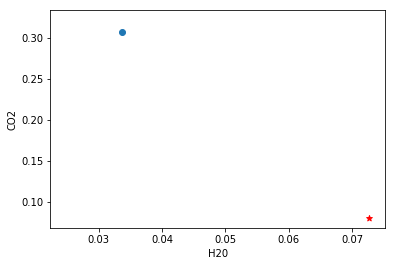

In [23]:
plt.scatter(predictions_val[:n,0],predictions_val[:n,1])
plt.scatter(y_data_val[0,0],y_data_val[0,1],color = 'r', marker = '*')
plt.xlabel(names[0])
plt.ylabel(names[1])
plt.show()

In [24]:
y_data_val[:,0]

array([0.07268674, 0.06683685, 0.02963555, ..., 0.03489806, 0.01563295,
       0.07837218])

# Plot is not too important, it is a histogram of abundances with the true values as stars.

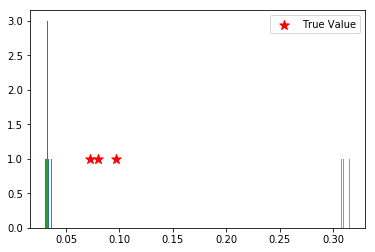

In [25]:
plt.hist(predictions_val[:,0],bins=20)
plt.hist(predictions_val[:,1],bins=20)
plt.hist(predictions_val[:,-1],bins=20)
plt.scatter([y_data_val[0,0],y_data_val[0,1],y_data_val[0,-1]],[1,1,1],color = 'red',s=100, marker = '*',label='True Value')
plt.legend()
plt.show()

In [26]:
y_data_val.shape

(10000, 5)

In [27]:
predictions_val[:,0]

array([0.03371353, 0.03159767, 0.03129429, 0.0329015 , 0.03210761,
       0.03072098, 0.03279805, 0.03329449, 0.03624349, 0.03271386])

## Generate samples for validation data
* For each planet sample TxN_ensemble abundances

In [28]:
No_pred = 100 # Number of planets to predict over
T=100 # Number of samples from the network per planet (e.g. 100 different H2O predictions to give a heat map)
PRED = np.zeros((No_pred,N_ensemble,T,num_features))
n = 0
for std_model in nn_ensemble:
    for planet in range(No_pred):
        PRED[planet,n] = np.array([std_model.predict(x_data_val[planet,:].reshape((1,-1,1))).reshape((1,num_features)) for _ in range(T)]).squeeze()
        print(planet,' planet completed')
    # predictions_test = pipeline.trees_predict(np.array(x_data_test)[0,:])
    print(n,' models completed')
    n += 1

0  planet completed
1  planet completed
2  planet completed
3  planet completed
4  planet completed
5  planet completed
6  planet completed
7  planet completed
8  planet completed
9  planet completed
10  planet completed
11  planet completed
12  planet completed
13  planet completed
14  planet completed
15  planet completed
16  planet completed
17  planet completed
18  planet completed
19  planet completed
20  planet completed
21  planet completed
22  planet completed
23  planet completed
24  planet completed
25  planet completed
26  planet completed
27  planet completed
28  planet completed
29  planet completed
30  planet completed
31  planet completed
32  planet completed
33  planet completed
34  planet completed
35  planet completed
36  planet completed
37  planet completed
38  planet completed
39  planet completed
40  planet completed
41  planet completed
42  planet completed
43  planet completed
44  planet completed
45  planet completed
46  planet completed
47  planet completed
48

In [29]:
PRED.shape

(100, 1, 100, 5)

In [30]:
PRED_o = PRED[:]

In [31]:
PRED = PRED_o[:,:n].reshape((No_pred,-1,num_features))

# Plots: predictions vs true for validation
* Red line is the y = x just to show if there is correlation

### For Earth append to end of validation and look at the last value for the validation

For  100  validation planets:

H20 MSE:  0.0007132421189967285  2 Standard Deviations on MSE:  0.005600711293379729


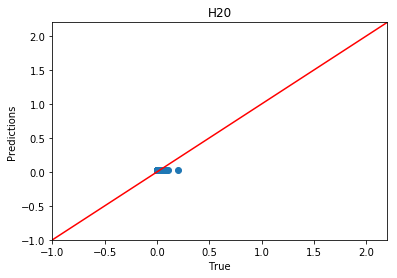

For  100  validation planets:

CO2 MSE:  0.02167283747052713  2 Standard Deviations on MSE:  0.05782210731051511


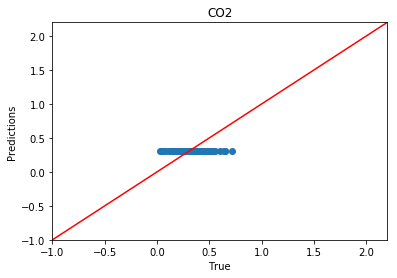

For  100  validation planets:

O2 MSE:  0.024859750306583373  2 Standard Deviations on MSE:  0.04937743491768666


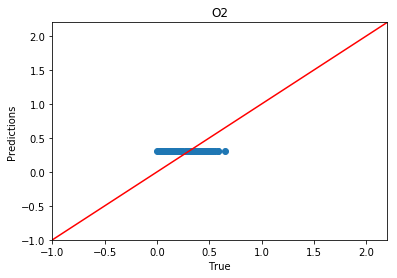

For  100  validation planets:

N2 MSE:  0.025036964279921588  2 Standard Deviations on MSE:  0.05814967235318826


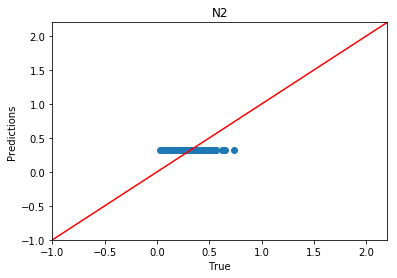

For  100  validation planets:

CH4 MSE:  0.0006624021639530611  2 Standard Deviations on MSE:  0.0025530701147233608


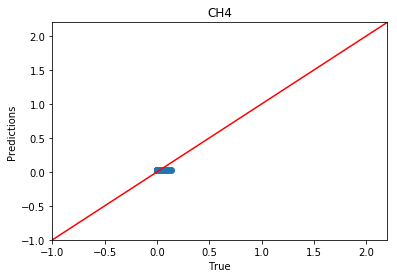

In [32]:
yyy = [-20,20] # This is just defining y = x
minx = np.min(y_data_val[:No_pred,:])
maxx = np.max(y_data_val[:No_pred,:])
miny = np.min(PRED.mean(1)[:,:])
maxy = np.max(PRED.mean(1)[:,:])
for mol in range(5):
    plt.title(names[mol])
    plt.ylabel('Predictions')
    plt.xlabel('True')
#     minx = np.min(y_data_val[:No_pred,mol])
#     maxx = np.max(y_data_val[:No_pred,mol])
#     miny = np.min(PRED.mean(1)[:,mol])
#     maxy = np.max(PRED.mean(1)[:,mol])
    plt.xlim([-1,2.2])
    plt.ylim([-1,2.2])
    plt.scatter(y_data_val[:No_pred,mol],PRED.mean(1)[:,mol])
    plt.plot(yyy,yyy,'r')
    
    print('For ',No_pred,' validation planets:\n')
    # MSE: 
    MSE = np.mean((y_data_val[:No_pred,mol]  - PRED.mean(1)[:,mol])**2)
    sig = np.std((y_data_val[:No_pred,mol]  - PRED.mean(1)[:,mol])**2)
    print(names[mol] + ' MSE: ',MSE, ' 2 Standard Deviations on MSE: ',2*sig)
    
    
#     plt.savefig('../figures/valid/'+names[mol]+'pred_vs_true_CNN_1_network.png')
    plt.show()

## HELA PLOTTING FUNCTION

In [51]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn import metrics, neighbors
from sklearn.preprocessing import MinMaxScaler


def predicted_vs_real(y_real, y_pred, names, ranges):
    
    num_plots = y_pred.shape[1]
    num_plot_rows = int(np.sqrt(num_plots))
    num_plot_cols = (num_plots - 1) // num_plot_rows + 1
    
    fig, axes = plt.subplots(num_plot_rows, num_plot_cols,
                             figsize=(5*num_plot_cols, 5*num_plot_rows))
    
    for dim, (ax, name_i, range_i) in enumerate(zip(axes.ravel(), names, ranges)):
        
        current_real = y_real[:, dim]
        current_pred = y_pred[:, dim]
        
        r2 = metrics.r2_score(current_real, current_pred)
        label = "$R^2 = {:.3f}$".format(r2)
        ax.plot(current_real, current_pred, '.', label=label)
        
        ax.plot(range_i, range_i, '--', linewidth=3, color="C3")
        
        ax.axis("equal")
        ax.grid()
        ax.set_xlim(range_i)
        ax.set_ylim(range_i)
        ax.set_xlabel("Real {}".format(name_i), fontsize=18)
        ax.set_ylabel("Predicted {}".format(name_i), fontsize=18)
        ax.legend(loc="upper left", fontsize=14)
    
    fig.tight_layout()
    return fig


def feature_importances(forests, names, colors):
    
    num_plots = len(forests)
    num_plot_rows = (num_plots - 1) // 2 + 1
    num_plot_cols = 2
    
    fig, axes = plt.subplots(num_plot_rows, num_plot_cols,
                             figsize=(15, 3.5*num_plot_rows))
    
    for ax, forest_i, name_i, color_i in zip(axes.ravel(), forests, names, colors):
        ax.bar(np.arange(len(forest_i.feature_importances_)), forest_i.feature_importances_,
               label="Importance for {}".format(name_i),
               width=0.4, color=color_i)
        ax.set_xlabel("Feature index", fontsize=18)
        ax.legend(fontsize=16)
        ax.grid()
    
    fig.tight_layout()
    return fig


def posterior_matrix(estimations, y, names, ranges, colors, soft_colors=None):
    
    cmaps = [LinearSegmentedColormap.from_list("MyReds", [(1, 1, 1), c], N=256)
             for c in colors]
    
    ranges = np.array(ranges)
    
    if soft_colors is None:
        soft_colors = colors
    
    num_dims = estimations.shape[1]
    
    fig, axes = plt.subplots(nrows=num_dims, ncols=num_dims,
                             figsize=(2 * num_dims, 2 * num_dims))
    fig.subplots_adjust(left=0.07, right=1-0.05,
                        bottom=0.07, top=1-0.05,
                        hspace=0.05, wspace=0.05)
    
    for ax, dims in zip(axes.flat, product(range(num_dims), range(num_dims))):
        dims = list(dims[::-1])
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.title.set_visible(False)
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
            ax.yaxis.set_visible(True)
            if names is not None:
                ax.set_ylabel(names[dims[1]], fontsize=18)
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
            ax.yaxis.set_visible(True)
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
            ax.xaxis.set_visible(True)
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')
            ax.xaxis.set_visible(True)
            if names is not None:
                ax.set_xlabel(names[dims[0]], fontsize=18)
        if ax.is_first_col() and ax.is_first_row():
            ax.yaxis.set_visible(False)
            ax.set_ylabel("")
        if ax.is_last_col() and ax.is_last_row():
            ax.yaxis.set_visible(False)
        
        if dims[0] < dims[1]:
            locations, kd_probs, *_ = _kernel_density_joint(estimations[:, dims], ranges[dims])
            ax.contour(locations[0], locations[1],
                       kd_probs,
                       colors=colors[dims[0]],
                       linewidths=0.5
                       # 'copper', # 'hot', 'magma' ('copper' with white background)
                      )
            histogram, grid_x, grid_y = _histogram(estimations[:, dims], ranges[dims])
            ax.pcolormesh(grid_x, grid_y, histogram, cmap=cmaps[dims[0]])
            
            expected = np.median(estimations[:, dims], axis=0)
            ax.plot([expected[0], expected[0]], [ranges[dims[1]][0], ranges[dims[1]][1]], '-', linewidth=1, color='#222222')
            ax.plot([ranges[dims[0]][0], ranges[dims[0]][1]], [expected[1], expected[1]], '-', linewidth=1, color='#222222')
            ax.plot(expected[0], expected[1], '.', color='#222222')
            ax.axis('normal')
            if y is not None:
                real = y[dims]
                ax.plot(real[0], real[1], '*', markersize=10, color='#FF0000')
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     ranges[dims[1]][0], ranges[dims[1]][1]])
        elif dims[0] > dims[1]:
            ax.plot(estimations[:, dims[0]], estimations[:, dims[1]], '.', color=soft_colors[dims[1]])
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     ranges[dims[1]][0], ranges[dims[1]][1]])
        else:
            histogram, bins = _histogram(estimations[:, dims[:1]], ranges=ranges[dims[:1]])
            ax.bar(bins[:-1], histogram, color=soft_colors[dims[0]], width=bins[1]-bins[0])
            
            kd_probs = histogram
            expected = np.median(estimations[:, dims[0]])
            ax.plot([expected, expected], [0, 1.1 * kd_probs.max()], '-', linewidth=1, color='#222222')
            
            if y is not None:
                real = y[dims[0]]
                ax.plot([real, real], [0, kd_probs.max()], 'r-')
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     0, 1.1 * kd_probs.max()])
    
    # fig.tight_layout(pad=0)
    return fig


def _min_max_scaler(ranges, feature_range=(0, 100)):
    res = MinMaxScaler()
    res.data_max_ = ranges[:, 1]
    res.data_min_ = ranges[:, 0]
    res.data_range_ = res.data_max_ - res.data_min_
    res.scale_ = (feature_range[1] - feature_range[0]) / (ranges[:, 1] - ranges[:, 0])
    res.min_ = -res.scale_ * res.data_min_
    res.n_samples_seen_ = 1
    res.feature_range = feature_range
    return res


def _kernel_density_joint(estimations, ranges, bandwidth=1/25):
    
    ndims = len(ranges)
    
    scaler = _min_max_scaler(ranges, feature_range=(0, 100))
    
    bandwidth = bandwidth * 100
    # step = 1.0
    
    kd = neighbors.KernelDensity(bandwidth=bandwidth).fit(scaler.transform(estimations))
    locations1d = np.arange(0, 100, 1)
    locations = np.reshape(np.meshgrid(*[locations1d] * ndims), (ndims, -1)).T
    kd_probs = np.exp(kd.score_samples(locations))
    
    shape = (ndims,) + (len(locations1d),) * ndims
    locations = scaler.inverse_transform(locations)
    locations = np.reshape(locations.T, shape)
    kd_probs = np.reshape(kd_probs, shape[1:])
    return locations, kd_probs, kd


def _histogram(estimations, ranges, bins=20):
    
    if len(ranges) == 1:
        histogram, edges = np.histogram(estimations[:, 0], bins=bins, range=ranges[0])
        return histogram, edges
    
    if len(ranges) == 2:
        histogram, xedges, yedges = np.histogram2d(estimations[:, 0], estimations[:, 1], bins=bins, range=ranges)
        grid_x, grid_y = np.meshgrid(xedges, yedges)
        return histogram.T, grid_x, grid_y, 

## Go back to original scale: (Un-normalise)

In [53]:
# un-normalise
PRED_un = PRED * y_data.std(0)[:num_features] +y_data.mean(0)[:num_features]
y_data_val_un = y_data_val * y_data.std(0)[:num_features] +y_data.mean(0)[:num_features]

## Plot posteriors

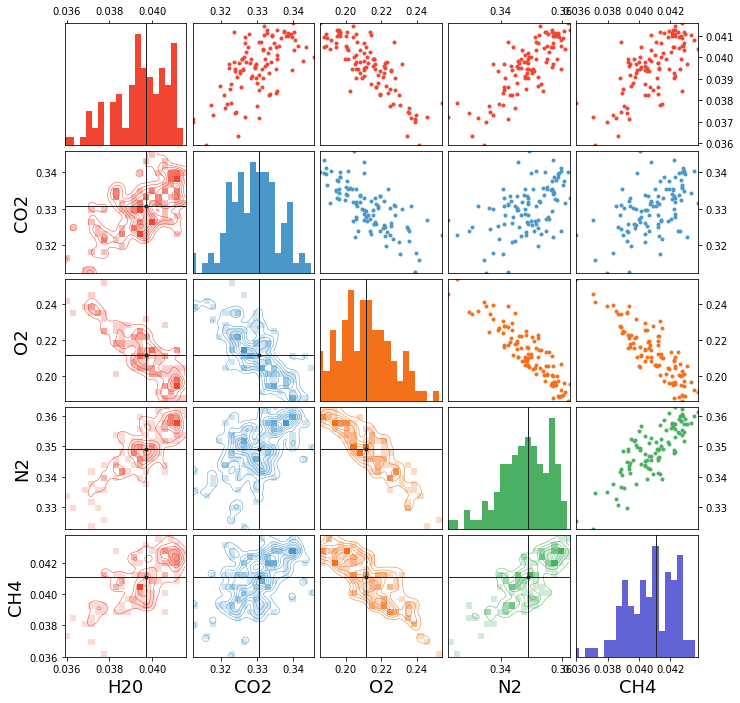

In [58]:
planet_id = 11#50
num_features = 5
# delta = 0.05
# ranges=[[x, y] for x, y in zip(y_data_val_un.min(0), y_data_val_un.max(0))]
# FOR ZOOMED IN UNCOMMENT LINE BELOW
ranges=[[x, y] for x, y in zip(PRED_un[planet_id,:,:num_features].min(0), PRED_un[planet_id,:,:num_features].max(0))]
# [[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, 1],[0, 1]]
names =  ["H20", "CO2", "O2", "N2", "CH4"]
colors = ["#F14532", "#4a98c9", "#f4701b", "#4bb062", "#6363d8"]#, "#F14532", "#4a98c9", "#f4701b", 
#           "#4bb062", "#6363d8","#4bb062", "#6363d8","#4a98c9", "#f4701b"]
posterior_matrix(PRED_un[planet_id,:,:num_features], y_data_val_un[planet_id,:num_features], names, ranges, colors, soft_colors=None)
# plt.savefig('../figures/CNN1_planet_id'+str(planet_id + Ntr)+'.pdf')
plt.show()

In [42]:
PRED_un = PRED * y_data.std(0) +y_data.mean(0)

In [43]:
y_data_val_un = y_data_val * y_data.std(0) +y_data.mean(0)

In [44]:
y_data_val_un - y_data[Ntr:,:]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])